In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [27]:

# Load your data
data = pd.read_csv("data_matrix_gpt-3.5-turbo.csv")

# Separate features and target
X = data.drop('label', axis=1)
y = data['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling data, as Logistic Regression is sensitive to feature scales
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
clf = LogisticRegression()  # Adjust max_iter as needed

param_grid = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'], 
        'penalty': ['l2', 'none'], 
        'C': np.logspace(-4, 4, 20),
        'max_iter' : [5000, 10000, 20000]  # increased max_iter values
    },
    {
        'solver': ['liblinear', 'saga'], 
        'penalty': ['l1', 'l2'], 
        'C': np.logspace(-4, 4, 20),
        'max_iter' : [5000, 10000, 20000]  # increased max_iter values
    },
    {
        'solver': ['saga'], 
        'penalty': ['elasticnet'], 
        'C': np.logspace(-4, 4, 20),
        'l1_ratio': np.linspace(0, 1, 10), # Only applicable for 'elasticnet'
        'max_iter' : [5000, 10000, 20000]  # increased max_iter values
    },
]

# Specify the number of combinations to sample
n_iter_search = 50  # Adjust this value as needed



In [28]:
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=n_iter_search, cv=5, verbose=0, n_jobs=-1)
random_search.fit(X_train, y_train)

# Use the best estimator to make predictions
model_best = random_search.best_estimator_



In [8]:
import pickle

# Save the model to a file
with open('best_estimator.pkl', 'wb') as f:
    pickle.dump(model_best, f)

# Later, you can load the model from the file like this:
with open('best_estimator.pkl', 'rb') as f:
    model_loaded = pickle.load(f)

In [29]:
y_pred = model_best.predict(X_test)


In [30]:
# Function for confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix', size = 15)
    plt.show()

In [31]:
def plot_coefficients(model, X):
    cols = X.columns

    # For binary classification
    if len(model.coef_) == 1:
        plt.figure(figsize=(10, 6))
        coef = model.coef_[0]
        sns.barplot(x=cols, y=coef)
        plt.xticks(rotation=90)
        plt.title('Feature Coefficients')

    # For multi-class classification
    else:
        plt.figure(figsize=(10, 6))
        coef = model.coef_
        sns.heatmap(coef, xticklabels=cols, cmap="RdBu_r")
        plt.xticks(rotation=90)
        plt.title('Feature Coefficients')

    plt.show()

In [32]:
# Function for ROC-AUC curve
def plot_roc_auc_curve(y_test, y_scores):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()


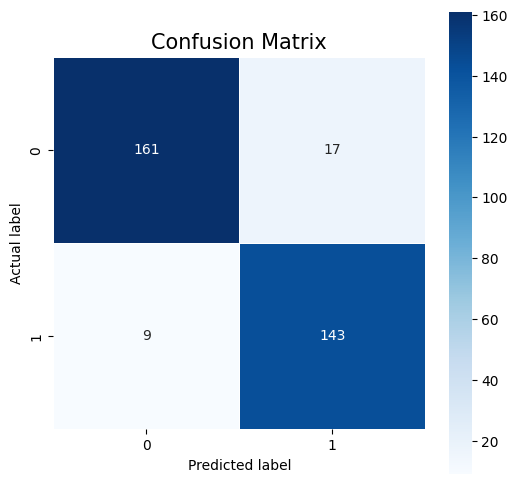

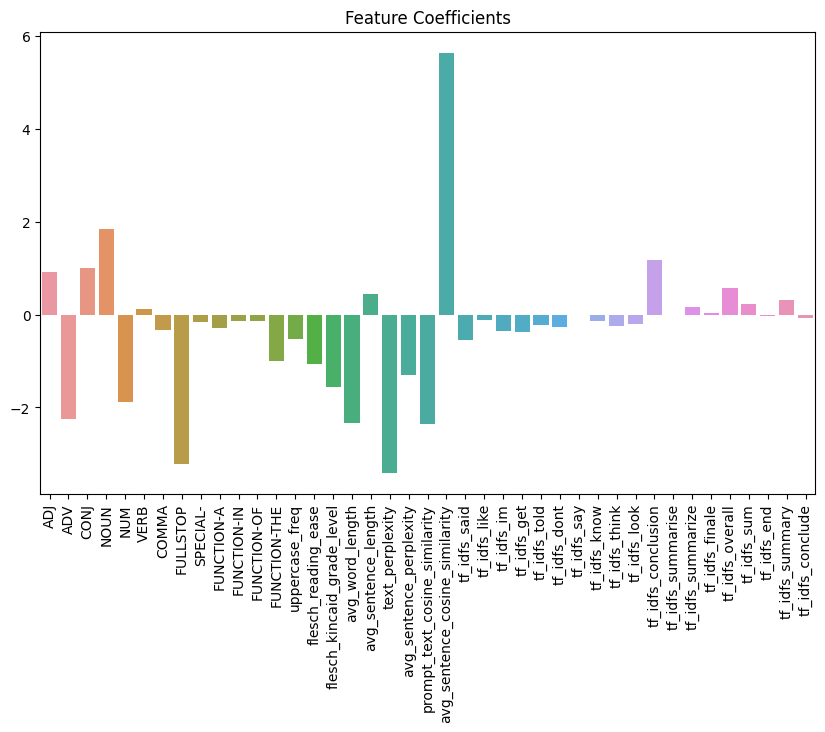

In [33]:
# Use the functions
plot_confusion_matrix(y_test, y_pred)
plot_coefficients(model_best, X)


In [34]:
y_scores = model_best.predict_proba(X_test)[:, 1]  # scores = proba of positive class


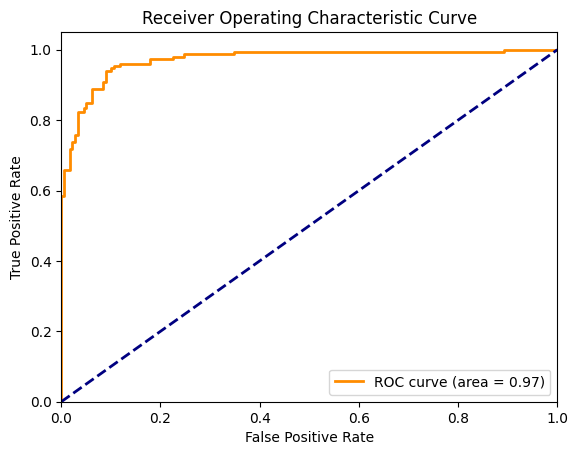

In [35]:
plot_roc_auc_curve(y_test, y_scores)  # you should compute y_scores first